In [4]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

In [69]:
casino = pd.read_csv('Online_casino_DIB.csv')
casino['ReqTimeUTC'] = pd.to_datetime(casino['ReqTimeUTC'])
casino = casino[casino['ReqTimeUTC'] <= '2020-02-29'].copy()
casino['TransactionType'] = casino['TransactionType'].map({'LOYALTYCARDDEBIT':'L2D', 'LOYALTYCARDCREDITCL':'L1D', 'LOYALTYCARDCREDIT':'L2W'})
casino = casino[(casino['TransactionType'] == 'L2D') & (casino['Status'] == 'APPROVED')].reset_index(drop=True)
casino = casino[['AccountIdentifier', 'ReqTimeUTC', 'TransactionAmount']]
casino = casino.sort_values(['AccountIdentifier', 'ReqTimeUTC']).reset_index(drop=True)
casino.rename(columns={'AccountIdentifier': 'customer', 'ReqTimeUTC':'timest', 'TransactionAmount': 'amount'}, inplace=True)
casino.head()

,customer,timest,amount
0,customer1,2019-03-01 17:24:43+00:00,30.0
1,customer1,2019-03-01 19:54:04+00:00,50.0
2,customer1,2019-03-01 22:44:15+00:00,40.0
3,customer1,2019-03-02 02:44:20+00:00,100.0
4,customer1,2019-03-02 18:28:39+00:00,25.0


In [37]:
casino.shape, casino['customer'].nunique()

((69734, 3), 2280)

### Feature Engineering

In [98]:
casino['period'] = casino['timest'].dt.strftime('%Y-%m')
casino

,customer,timest,amount,period
0,customer1,2019-03-01 17:24:43+00:00,30.0,2019-03
1,customer1,2019-03-01 19:54:04+00:00,50.0,2019-03
2,customer1,2019-03-01 22:44:15+00:00,40.0,2019-03
3,customer1,2019-03-02 02:44:20+00:00,100.0,2019-03
4,customer1,2019-03-02 18:28:39+00:00,25.0,2019-03
...,...,...,...,...
69729,customer997,2019-09-22 00:56:47+00:00,50.0,2019-09
69730,customer998,2019-11-09 07:03:51+00:00,25.0,2019-11
69731,customer998,2019-11-09 07:05:05+00:00,25.0,2019-11
69732,customer999,2019-03-20 10:58:04+00:00,250.0,2019-03


In [95]:
# for how long has the person been a customer?
base_timestamp = pd.to_datetime("2020-03-01 00:00:00+00:00") # the very last date in our analysis

In [150]:
customer_data = casino.groupby('customer').agg(
    first_active = ('timest', lambda x: (base_timestamp - x.dt.floor("d").min()).days),
    last_active = ('timest', lambda x: (base_timestamp - x.dt.floor("d").max()).days),
    tr_count = ('timest', 'count'),
    tr_sum = ('amount', 'sum'),
    tr_std = ('amount', 'std'),
    tr_period_avg = ('amount', lambda x: x.sum() / casino.loc[x.index, 'period'].nunique())
)
customer_data

,first_active,last_active,tr_count,tr_sum,tr_std,tr_period_avg
customer,,,,,,
customer1,366,2,444,34010.0,37.678533,2834.166667
customer10,364,2,1130,32089.0,13.940103,2674.083333
customer100,267,4,56,1639.0,9.195831,273.166667
customer1000,300,300,2,200.0,0.000000,200.000000
customer1001,225,21,23,689.0,13.769130,98.428571
...,...,...,...,...,...,...
customer995,304,2,6,348.5,19.800042,69.700000
customer996,353,170,3,50.0,7.637626,25.000000
customer997,161,161,1,50.0,NaN,50.000000


In [108]:
customer_data.isna().sum()

first_active       0
last_active        0
tr_count           0
tr_sum             0
tr_std           845
tr_period_avg      0
dtype: int64

In [135]:
customer_data.loc[customer_data['tr_std'].isna(), 'tr_std'] = 0.001
customer_data = customer_data.map(lambda x: 0.001 if x == 0 else x)

In [136]:
customer_data.isna().sum()

first_active     0
last_active      0
tr_count         0
tr_sum           0
tr_std           0
tr_period_avg    0
dtype: int64

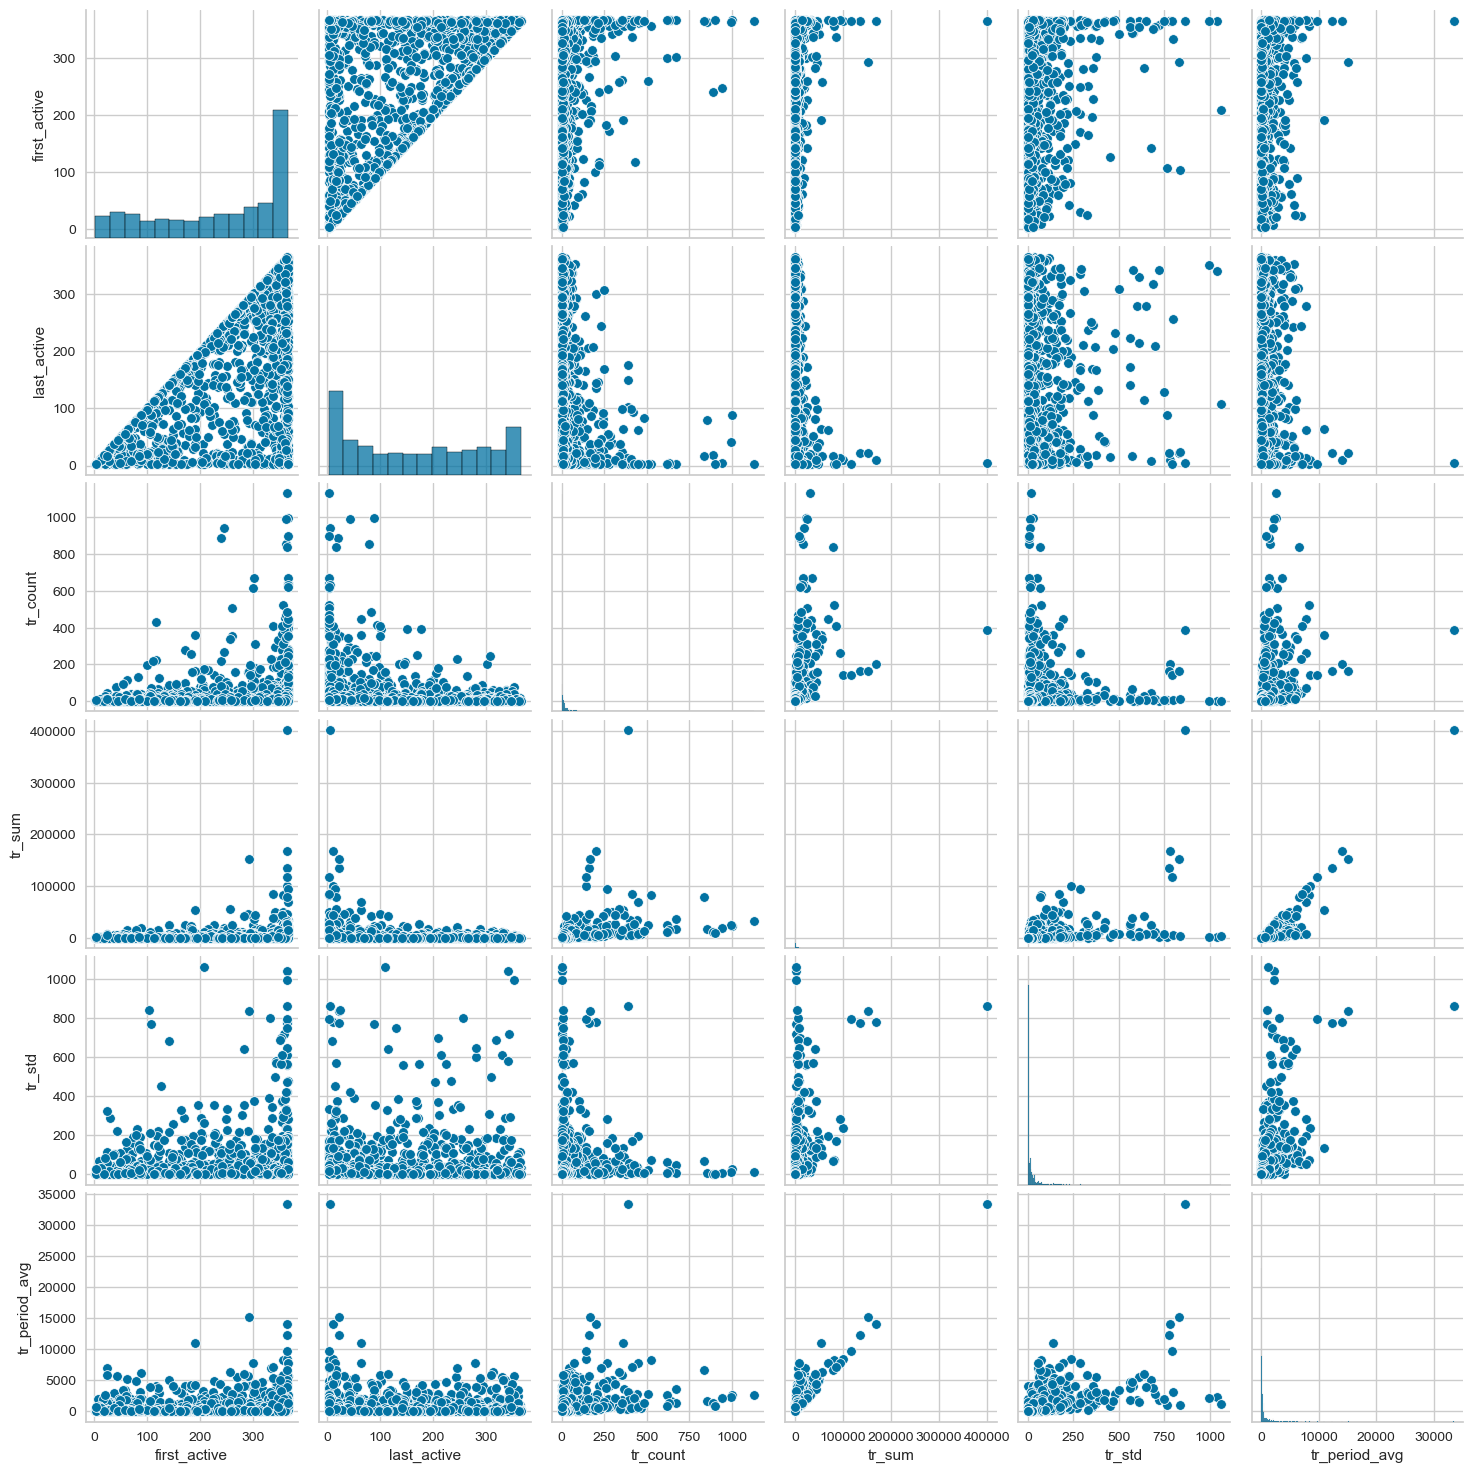

In [137]:
sns.pairplot(customer_data)

In [ ]:
X = customer_data[['first_active', 'last_active', 'tr_count', 'tr_sum', 'tr_std','tr_period_avg']]

first_active     0
last_active      0
tr_count         0
tr_sum           0
tr_std           0
tr_period_avg    0
dtype: int64

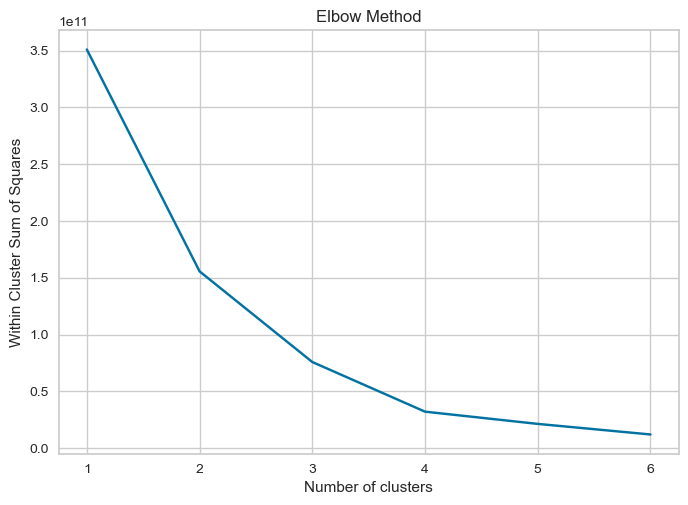

In [140]:
cluster = [1, 2, 3, 4, 5, 6]
wcss_ls = []
for i in cluster:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss = kmeans.inertia_ #Within Cluster Sum of Squares
    wcss_ls.append(wcss)

plt.plot(cluster, wcss_ls)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

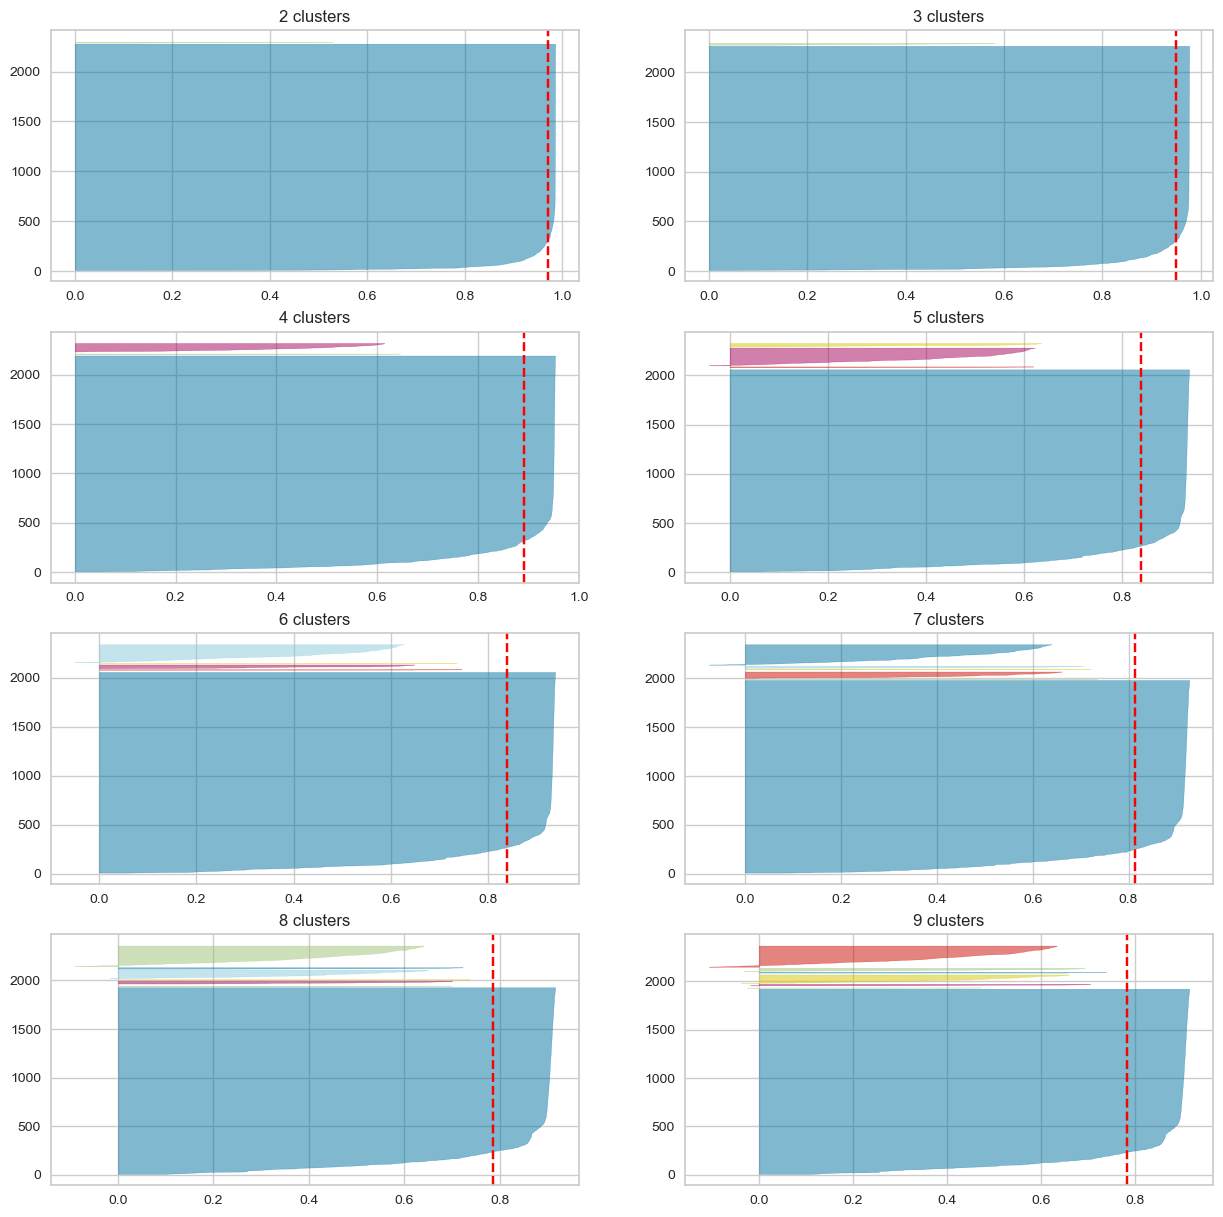

In [141]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
                    
    ''' 
    Create SilhoutteVisualizer instance with KMean instance
    Fit the visualizer
    '''

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    ax[q-1][mod].set_title(f'{i} clusters')

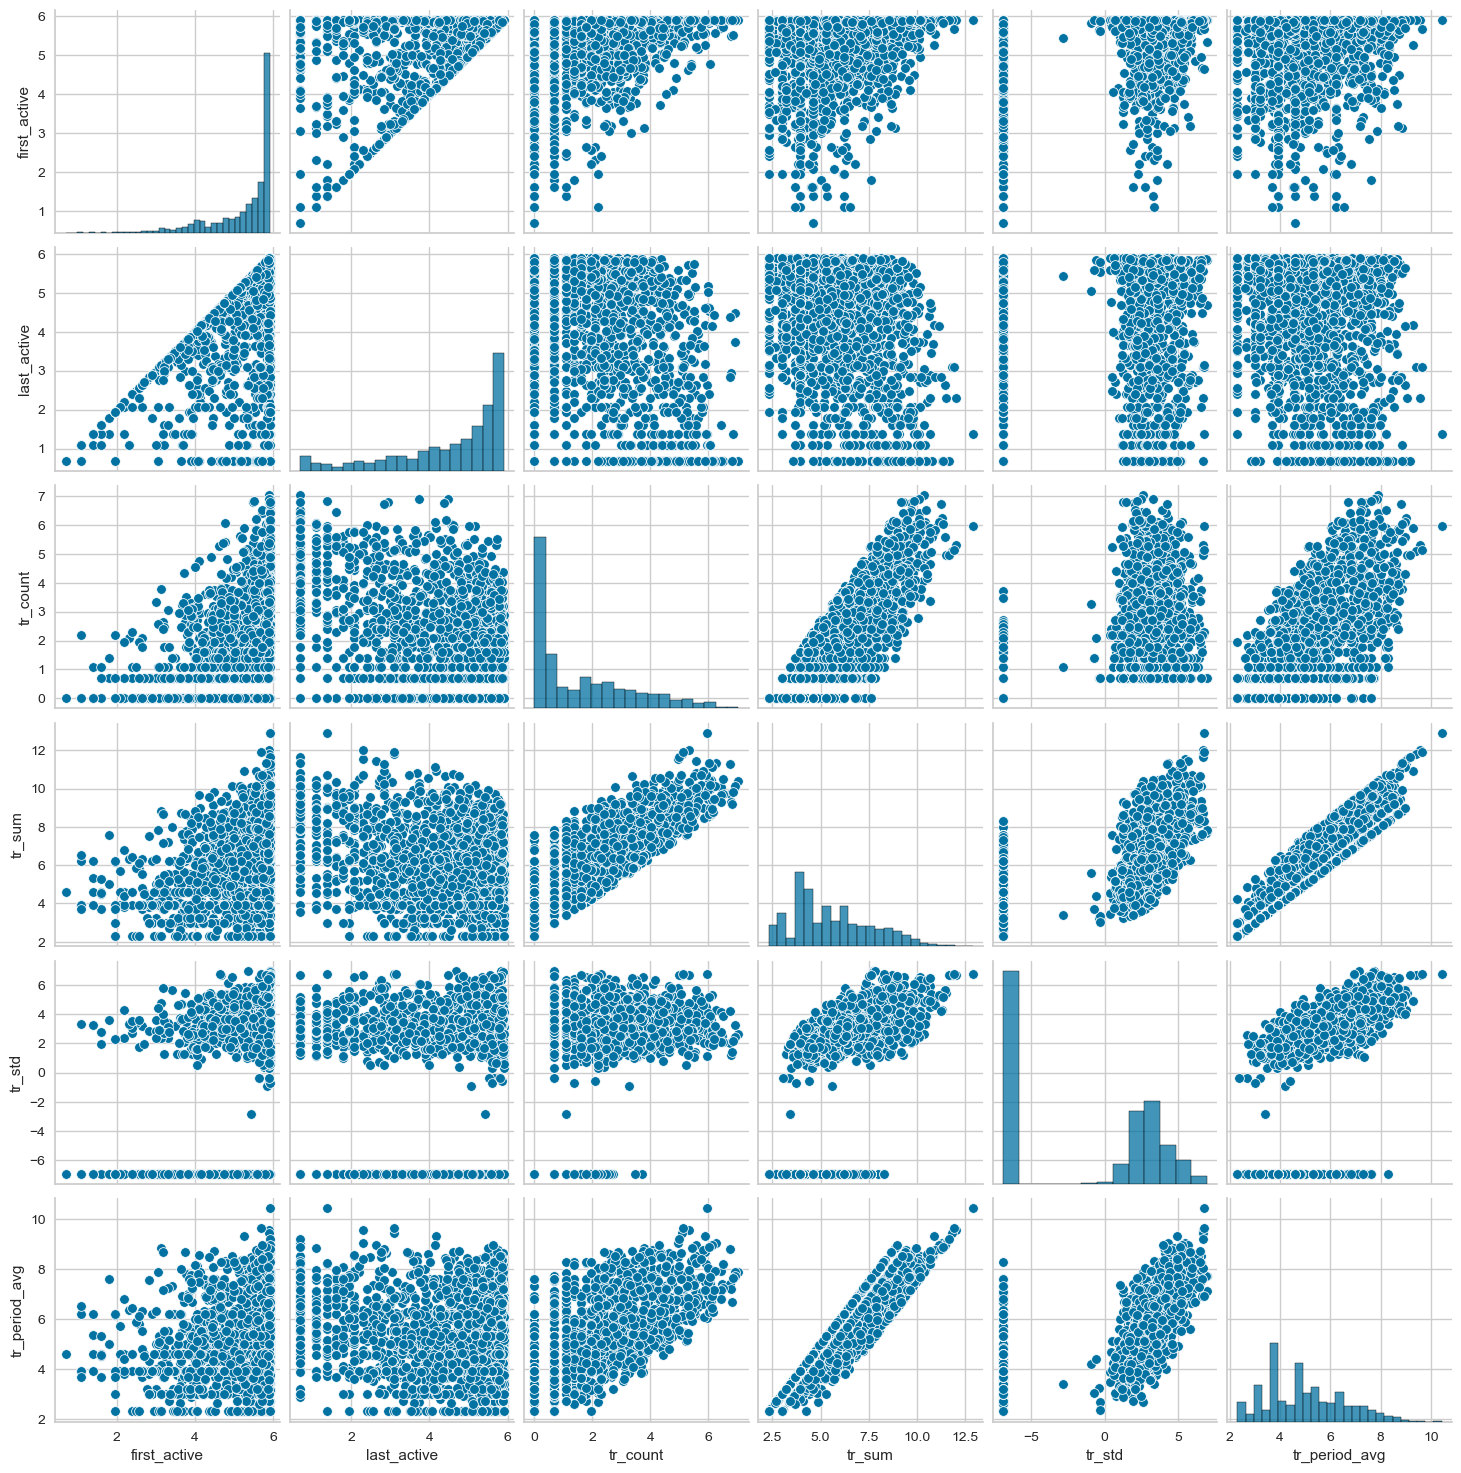

In [143]:
X_std = np.log(customer_data)
sns.pairplot(X_std)

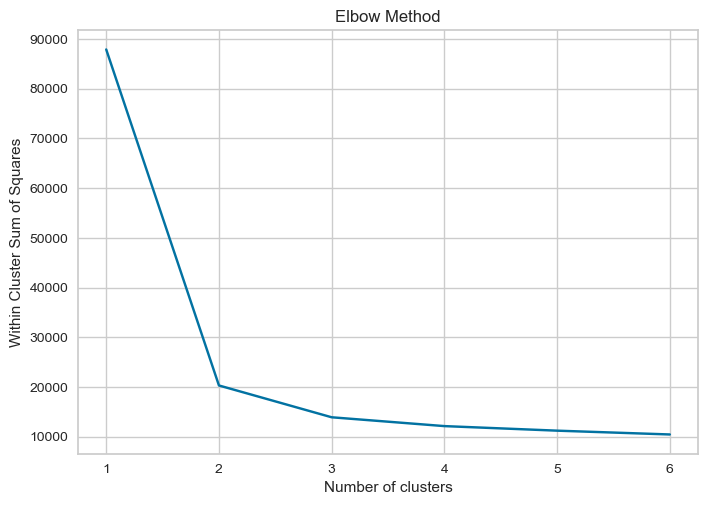

In [144]:
cluster = [1, 2, 3, 4, 5, 6]
wcss_ls = []
for i in cluster:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_std)
    wcss = kmeans.inertia_ #Within Cluster Sum of Squares
    wcss_ls.append(wcss)

plt.plot(cluster, wcss_ls)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

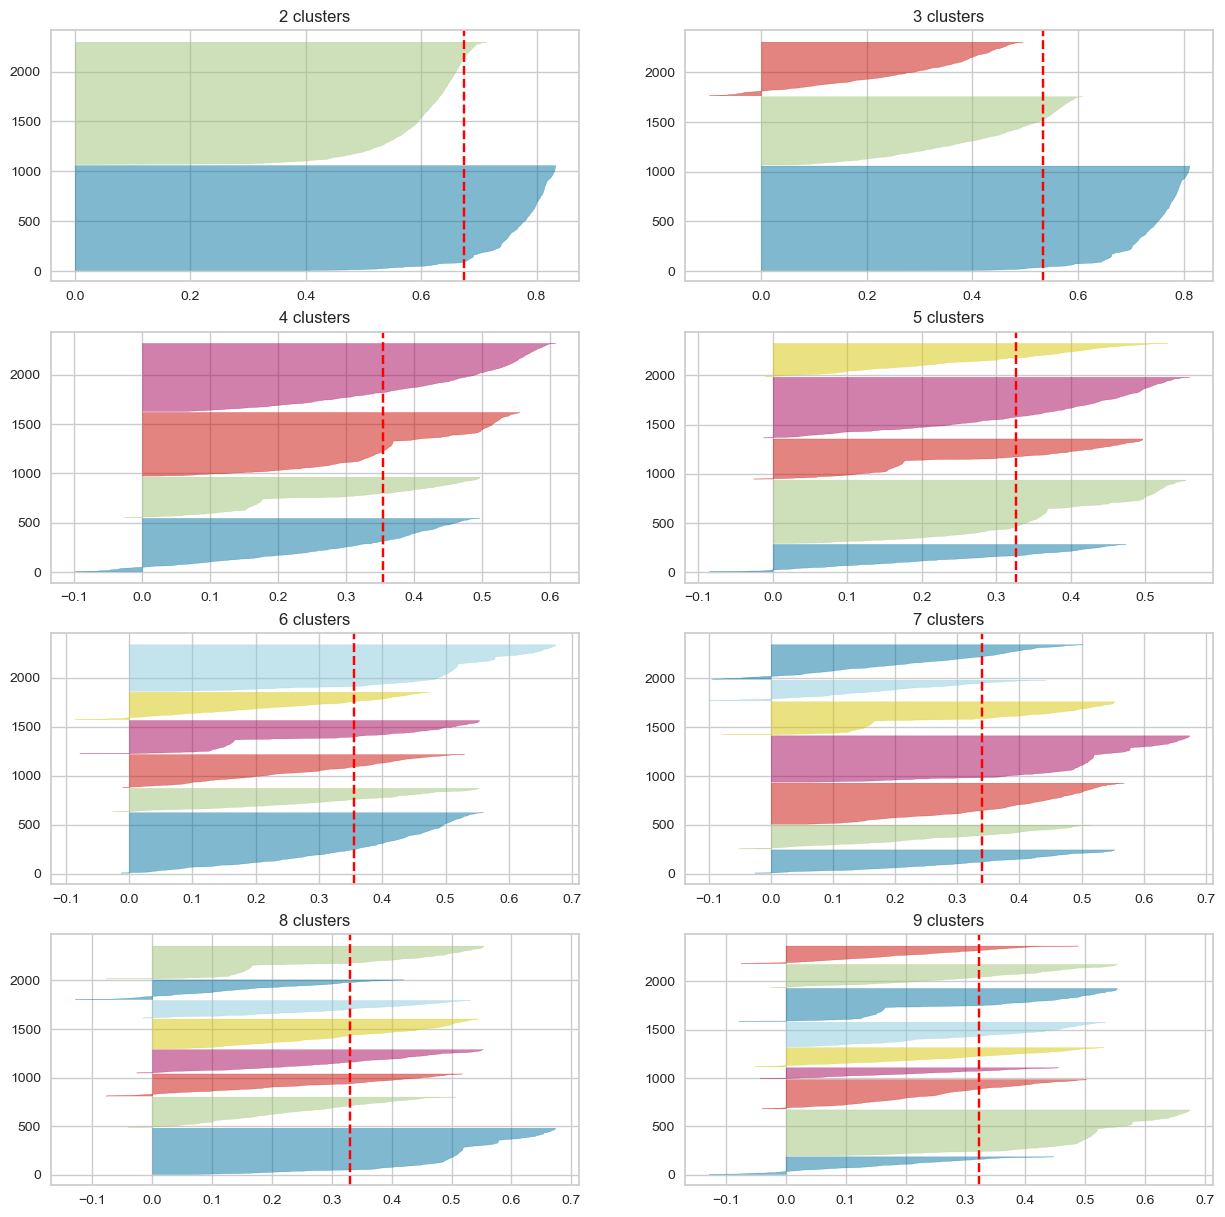

In [145]:
fig, ax = plt.subplots(4, 2, figsize=(15,15))

for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
                    
    ''' 
    Create SilhoutteVisualizer instance with KMean instance
    Fit the visualizer
    '''

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_std)
    ax[q-1][mod].set_title(f'{i} clusters')

In [151]:
customer_data['group'] = kmeans.labels_
customer_data

,first_active,last_active,tr_count,tr_sum,tr_std,tr_period_avg,group
customer,,,,,,,
customer1,366,2,444,34010.0,37.678533,2834.166667,2
customer10,364,2,1130,32089.0,13.940103,2674.083333,2
customer100,267,4,56,1639.0,9.195831,273.166667,4
customer1000,300,300,2,200.0,0.000000,200.000000,0
customer1001,225,21,23,689.0,13.769130,98.428571,3
...,...,...,...,...,...,...,...
customer995,304,2,6,348.5,19.800042,69.700000,3
customer996,353,170,3,50.0,7.637626,25.000000,1
customer997,161,161,1,50.0,NaN,50.000000,0


/var/folders/ky/1l79mmbn5y724s2qym0y5t_c0000gn/T/ipykernel_75687/1238709288.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x)


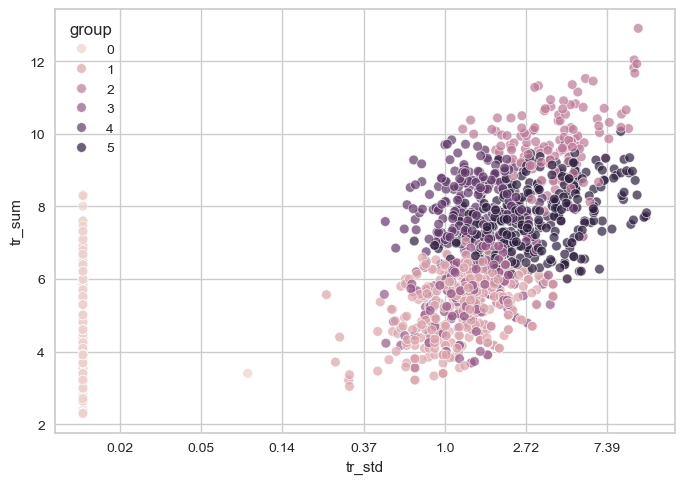

In [161]:
fig, ax = plt.subplots()
sns.scatterplot(X_std, x='tr_std', y='tr_sum', hue=customer_data['group'], alpha=0.7)
x = [0]
for i in range(-4, 8, 1):
    reversed_value = round(np.exp(i), 2)
    x.append(reversed_value)
ax.set_xticklabels(x)
plt.show()